In [1]:
# -*- coding: utf-8 -*-

# =======
# imports
# =======
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.unicode'] = False



# Introduction
The goal is to make a projection of the Willingness To Pay (WTP) for electricity in African households. We want to do this for each country, and then aggregate into TIAM-ECN regions.

Base year is 2010. WTP in 2010 is calculated as:

$$
WTP_{2010} = \frac{EEC_{2010} \times GDP_{2010}}{FEC_{2010}},
$$

where: 
- $EEC_{2010}$ = 2% is the electricity expenditure coefficient (as % of GDP). **Assumption**.
- $GDP_{2010}$ = GDP per capita (PPP). **World Bank**
- $FEC_{2010}$ = Final electricity consumption per connected person: 

$$
FEC_{2010} = \frac{EPC_{2010} \times (POP_{RUR}+POP_{URB})}{POP_{RUR} \times ACC_{RUR} + POP_{URB} \times ACC_{URB}},
$$

with:
- $EPC_{2010}$ = Electric power consumption per capita in 2010. **World Bank**
- $POP_x$ = Population rural or urban in 2010. **World Bank**
- $ACC_x$ = Share of pop with electricity access in 2010, rural or urban. **World Bank**.

To make aprojection for future years we let the WTP grow with the logarithm of the GDP: 

\begin{align}
WTP_y & = WTP_{2010} \times \frac{\log{(GDP_y)}}{\log{(GDP_{2010})}} \\ \nonumber \\
& = WTP_{2010} \times \frac{\log{(GDP_{2010} \times gc_y)}}{\log{(GDP_{2010)}}},
\end{align}

where: 
- $gc_{y}$ = GDP growth coefficient. **TIAM-ECN**

We need the following data: 
- **World Bank**
    - GDP per capita (PPP) in 2010 per country
    - Total population rural/urban in 2010 per country
    - Electricity access rural/urban in 2010 per country
    - Electric power consumption in 2010 per country
- **TIAM-ECN**
    - GDP growth coefficients per country
   

# $WTP_{2010}$

In [2]:
# First a function to calculte regional averages and use them to fill data gaps: 
def reg_mean_fill(df,skip_col=4,steps=False):
    """
    Takes DF and calculates regional averages for TIAM-ECN regions, and use them to fill any NaN in the original DF.
    It assumes df starts with a column named 'Country Name', then there are (skip_col-1) columns with text (indicator codes etc.), 
    then there are an arbitrary number of year columns, and finally it with a column named 'REG-TIAM_all'. 
    Error message otherwise.
    Setting steps to True returns a list with all the intermediate DFs. Default returns only the final DF with fillna.
    """
    
    check_format = [df.columns[0]=='Country Name', df.columns[-1]=='REG-TIAM_all']
    if check_format != [True, True]:
        print('Invalid DF format. Must start with Country Name and end with REG-TIAM_all')
        return None
    else:
        df1 = df.sort_values(by='Country Name').reset_index().drop('index',axis=1)
        rm1 = df1.groupby('REG-TIAM_all').mean().reset_index()
        rm2 = pd.concat([df1.iloc[:,:skip_col],df1.iloc[:,-1]],axis=1).merge(rm1, on='REG-TIAM_all')\
                                                                      .sort_values(by = 'Country Name')\
                                                                      .reset_index().drop('index',axis=1)
        df2 = df1.fillna(rm2)
        if steps: 
            return [df1,rm1,rm2,df2]
        else: 
            return df2


# ==========
# Input data
# ==========

data_dir = "input_data"

# Wrold regions and african countries
world_regions = pd.read_excel(data_dir+"\\country_mapping.xlsx", sheetname="regions")
afr_countries = world_regions[world_regions['REG-TIAM_15']=='AFR'].loc[:,['REG-TIAM_all', 'Country Name']]
afr_countries = afr_countries.drop(afr_countries[afr_countries['Country Name'] == '(blank)'].index, axis=0)

# GDP (PPP) historic [current international $ PPP]
gdp_his = pd.read_excel(data_dir+"\\GDP_PPP.xlsx", sheetname="Data", skiprows=3).merge(afr_countries, on='Country Name')
gdp_his = reg_mean_fill(gdp_his)

# Population historic and projection [nr of people]
pop = pd.read_excel(data_dir+"\\Population-EstimatesEXCEL.xlsx", sheetname="Data").merge(afr_countries, on='Country Name')
pop_rur = pop[pop['Indicator Name'] == 'Rural population'].reset_index().drop('index',axis=1)\
                                                          .merge(afr_countries, on='Country Name')
pop_urb = pop[pop['Indicator Name'] == 'Urban population'].reset_index().drop('index',axis=1)\
                                                          .merge(afr_countries, on='Country Name')

# Electricity access historic [% of total pop]
acc_rur = pd.read_excel(data_dir+"\\el_acc_rur.xlsx",sheetname="Data",skiprows=3)\
            .merge(afr_countries, on='Country Name')
acc_urb = pd.read_excel(data_dir+"\\el_acc_urb.xlsx",sheetname="Data",skiprows=3)\
            .merge(afr_countries, on='Country Name')

# Electric power consumption historic [kWh per capita] 
epc = pd.read_excel(data_dir+"\\el_cons.xlsx", sheetname="Data", skiprows=3).merge(afr_countries, on='Country Name')
epc = reg_mean_fill(epc)
#epc = gdp_his.iloc[:,[0,-1]]
#epc = epc.merge(pd.read_excel(data_dir+"\\el_cons_resid.xlsx", sheetname="Data"), on='Country Name')
#epc



C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [3]:
# Check for gaps in 2010
print('GDP\n',gdp_his[gdp_his['2010'].isnull()])
print('POP_RUR\n',pop_rur[pop_rur['2010'].isnull()])
print('POP_URB\n',pop_urb[pop_urb['2010'].isnull()])
print('ACC_RUR\n',acc_rur[acc_rur['2010'].isnull()])
print('ACC_URB\n', acc_urb[acc_urb['2010'].isnull()])
print('EPC\n',epc[epc['2010'].isnull()])

GDP
 Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, REG-TIAM_all]
Index: []

[0 rows x 62 columns]
POP_RUR
 Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,

The report indicates that for ACC_URB there are no 2010 values for Equatorial Guinea. However there is a value for 2011, so we can use Pandas interpolation to etxted the 2011 backwards to 2010 (done in cell FEC_2010 below). 

For EPC there are no values for Madagascar. Here it's a bit more problematic because there are no values also for the other years. The World Bank and IEA do not have freely available data on electricity consumption in MDG. I found some 2012 data from the MDG statistical office (https://www.instat.mg/wp-content/uploads/2016/11/INSTAT_Tbe16-07-2014.pdf). We'll manually input them. Let's fix this right away:

In [4]:
mdg_idx = epc[epc['Country Name']=='Madagascar'].index.values[0]
mdg_pop_2010 = pop_rur[pop_rur['Country Name']=='Madagascar']['2010'].values[0]+\
               pop_urb[pop_urb['Country Name']=='Madagascar']['2010'].values[0]
epc.loc[mdg_idx,'2010'] = 73617000 / mdg_pop_2010
print('EPC\n',epc[epc['2010'].isnull()],'\n', epc.loc[mdg_idx,'2010'])

EPC
 Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, REG-TIAM_all]
Index: []

[0 rows x 63 columns] 
 3.48043934182


Good, epc is fixed (though the value for MDG is very low). We can now proceed to calculate the FEC:

In [5]:
# ========
# FEC_2010
# ========
# Final electricity consumption per connected person
c = 'Country Name'
y = '2010'
pop_tot_2010 = pop_rur.loc[:,[c,y]].pivot_table(index = c) + pop_urb.loc[:,[c,y]].pivot_table(index = c)
epc_2010 = epc.loc[:,[c,y]].pivot_table(index = c)
acc_rur_2010 = acc_rur.loc[:,[c,y]].pivot_table(index = c) * pop_rur.loc[:,[c,y]].pivot_table(index = c) / 100.
acc_urb_2010 = acc_urb.loc[:,[c,y]].pivot_table(index = c).interpolate() * pop_urb.loc[:,[c,y]].pivot_table(index = c) / 100.

fec_2010 = pop_tot_2010 * epc_2010 / (acc_urb_2010 + acc_rur_2010)
#fec_2010 = 2.778e+8 * epc_2010 / (acc_urb_2010 + acc_rur_2010)
fec_2010.head()

,2010
Country Name,
Algeria,1018.866491
Angola,587.329146
Benin,269.194695
Botswana,3207.290932
Burkina Faso,1184.212234


Now that we have the FEC in 2010, let's sort the data in ascending order and plot them

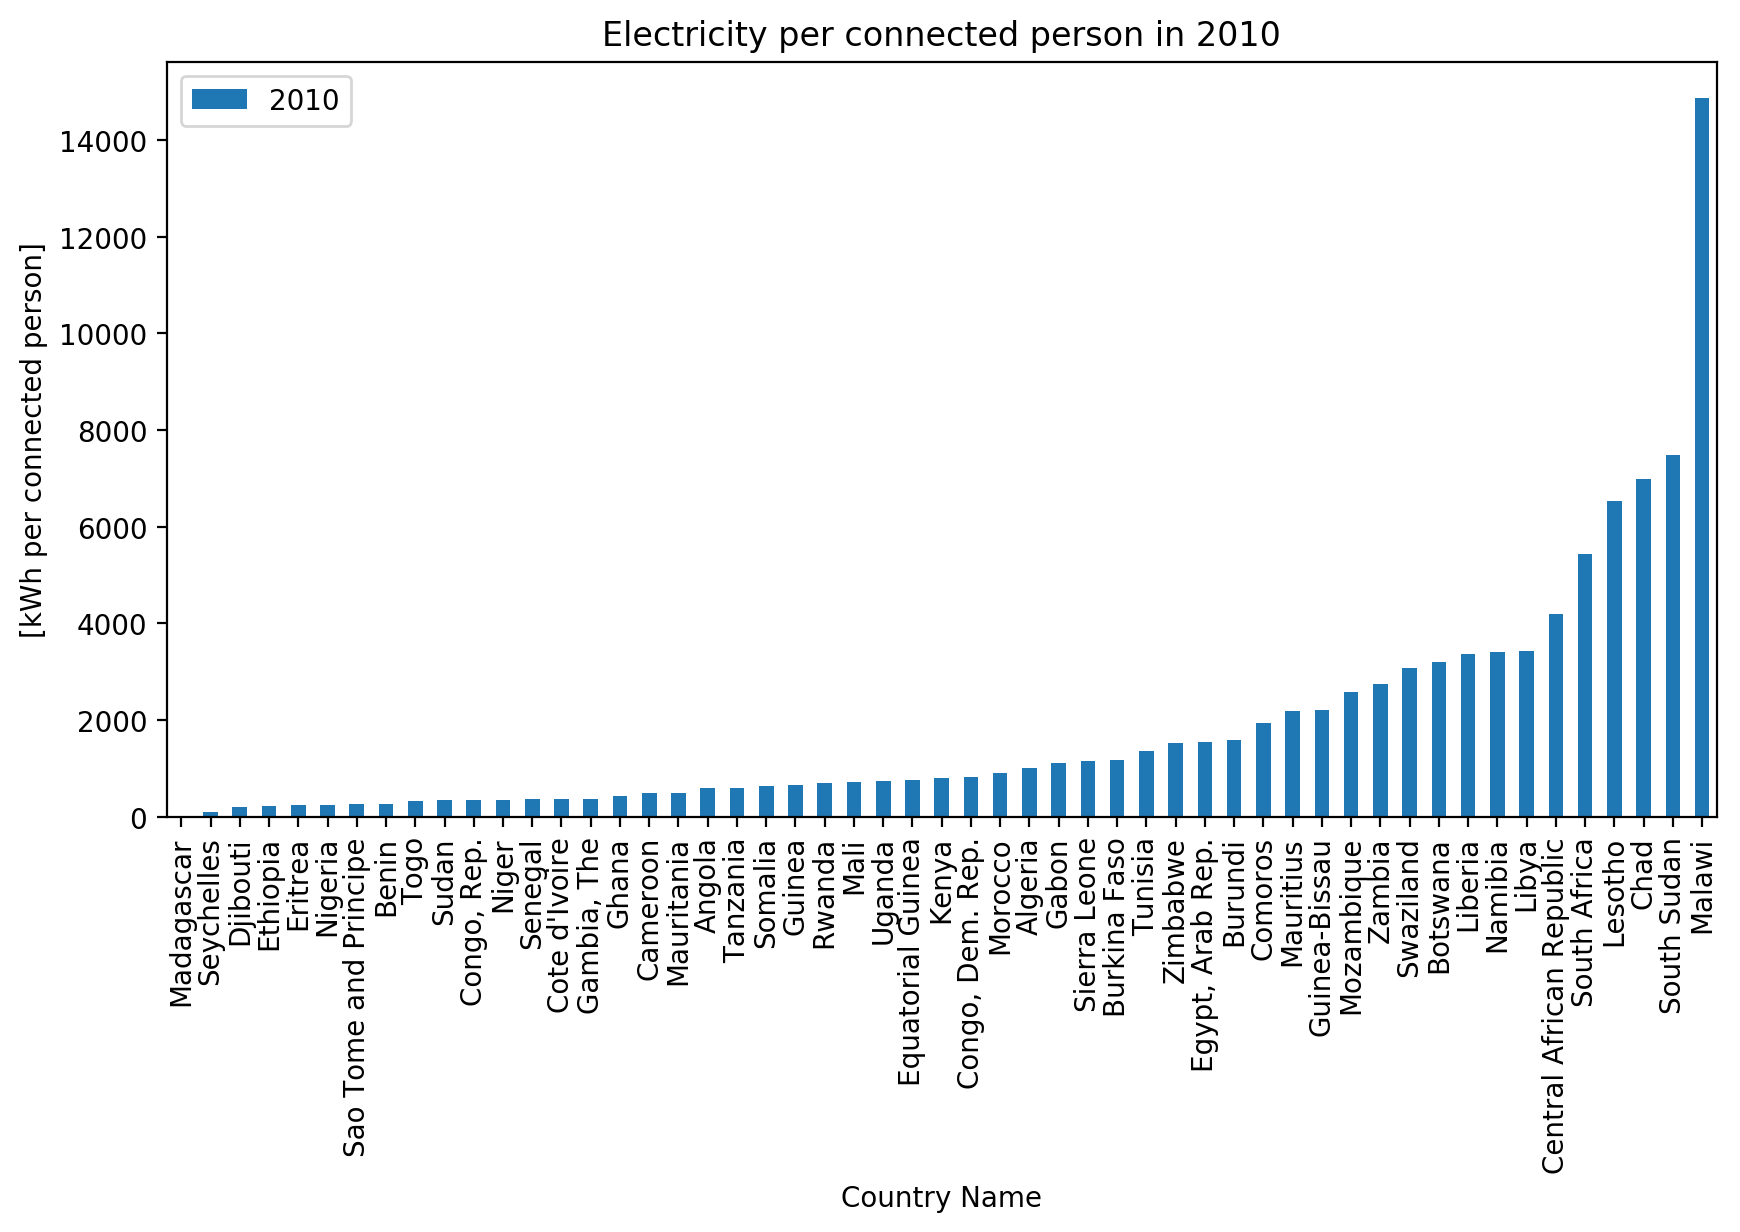

In [6]:
fec_2010.sort_values(by='2010').plot(kind='bar', figsize=(10,5))
plt.ylabel('[kWh per connected person]')
plt.title('Electricity per connected person in 2010')
plt.gcf().set_dpi(200)

We see that the distribution is highly asymmetrical, with a few countries that have very high FEC.

A similar (though not as extreme) trend can be oserved for the GDP:

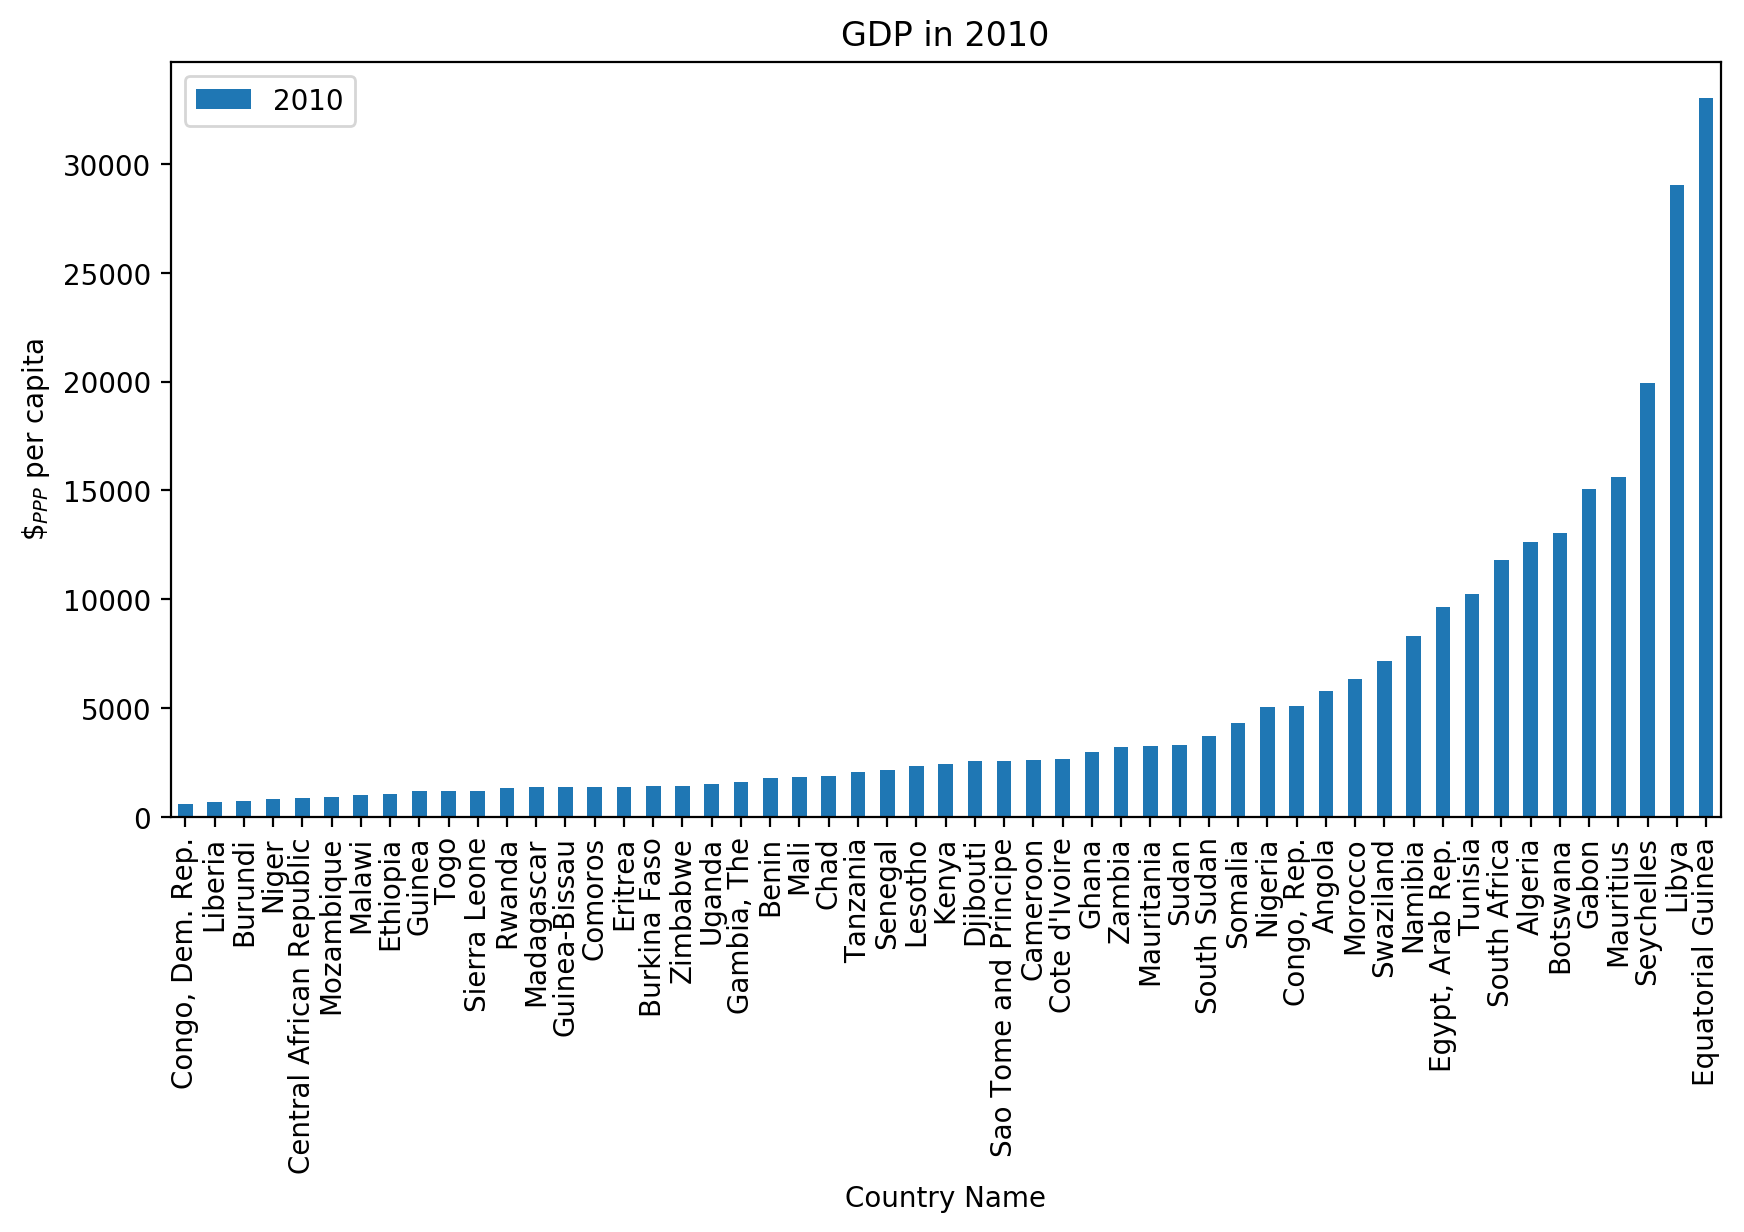

In [7]:
gdp_2010 = gdp_his.loc[:,[c,y]].pivot_table(index = c)
gdp_2010.sort_values(by='2010').plot(kind='bar',figsize=(10,5))
plt.ylabel(r'$\$_{PPP}$ per capita')
plt.title('GDP in 2010')
plt.gcf().set_dpi(200)

Now that we have FEC and GDP in 2010, we can also calculate the WTP:

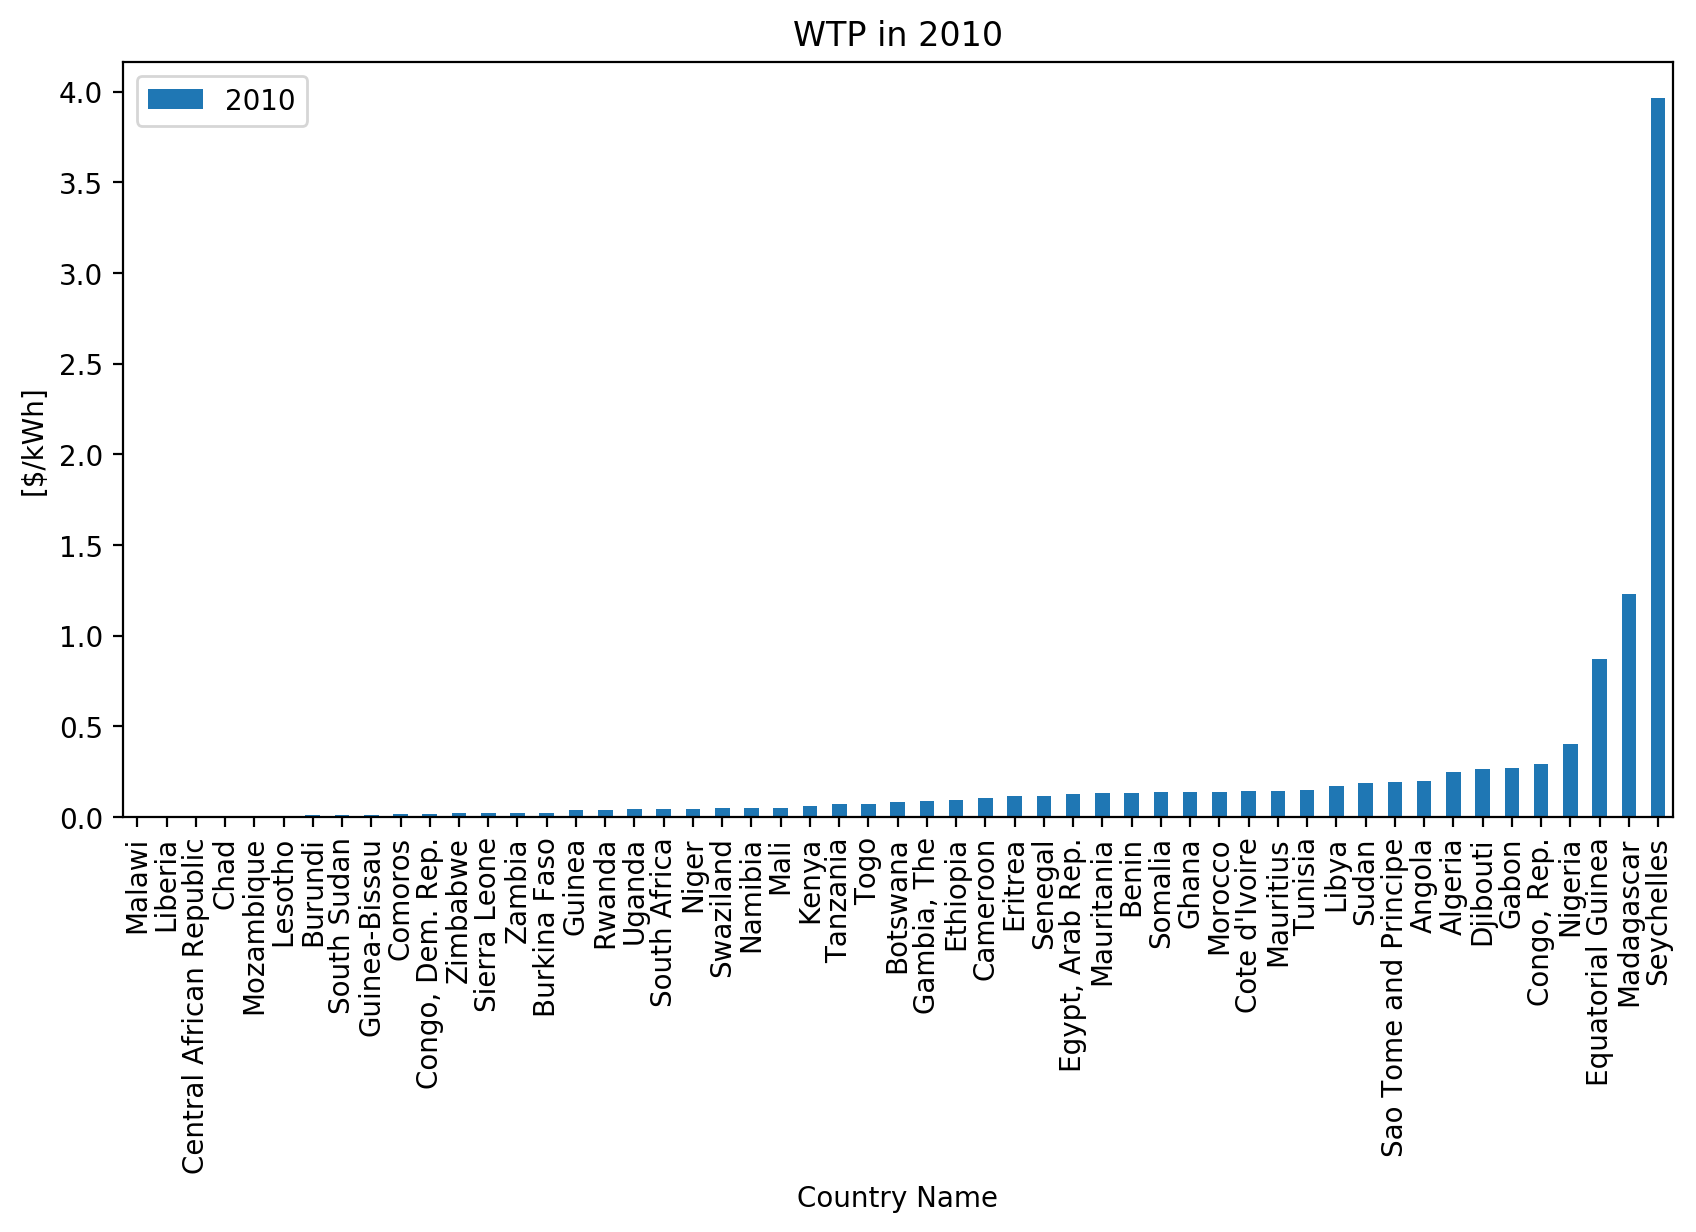

In [8]:
wtp_2010 = gdp_2010 * 0.02 / fec_2010
wtp_2010.sort_values(by='2010').plot(kind='bar',figsize=(10,5))
plt.ylabel('[$/kWh]')
plt.title('WTP in 2010')
plt.gcf().set_dpi(200)

The high asymmetry in the FEC and GDP distributions is reflected in the WTP distribution, yeilding unrealistically high/low values at either end of the distribution (and reflecting the oversimplified nature of our approach). 

A realistic WTP estimate should be comparable to the LCOE of typical power supply technologies, and/or in the range of observed electricity prices. WTP values above 0.5 $/kWh for example are very unlikely. These very high/low values occur when the ratio between GDP and FEC is much higher/lower than average.  

To overcome this issue without introducing a more complex model (which we might want to do in the future), we can make a box-plot find the WTP range where most of the data-points fall:  

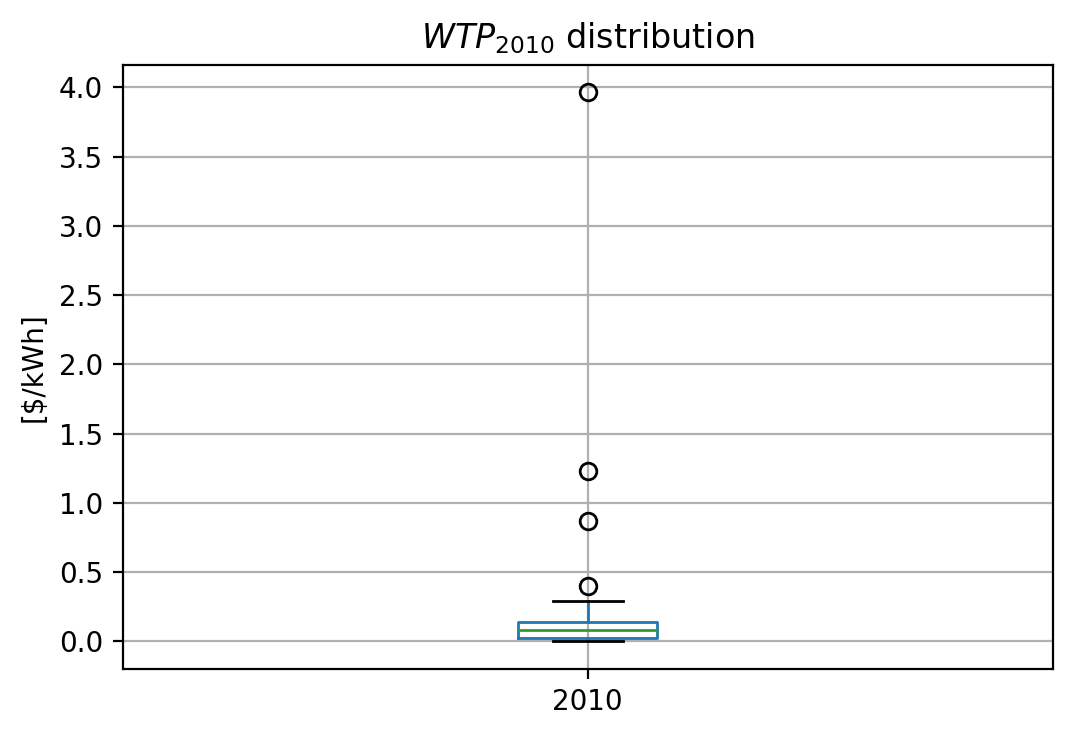

In [9]:
wtp_2010.boxplot()
plt.ylabel('[$/kWh]')
plt.title('$WTP_{2010}$ distribution')
plt.gcf().set_dpi(200)

We see that most datapoints fall in the range between 0.01 and 0.15 $/kWh. This is also the range where most LCOEs and (consumer)  electricity prices fall - hence this finding validates our approach, and we can consider very high and very low WTPs as outliers caused by factors that our approach does not properly address. Based on this, we then apply a low and high cutoff to our WTPs at the first, resp. last, quartile (i.e. percentiles 25%, resp. 75% of our distribution):   

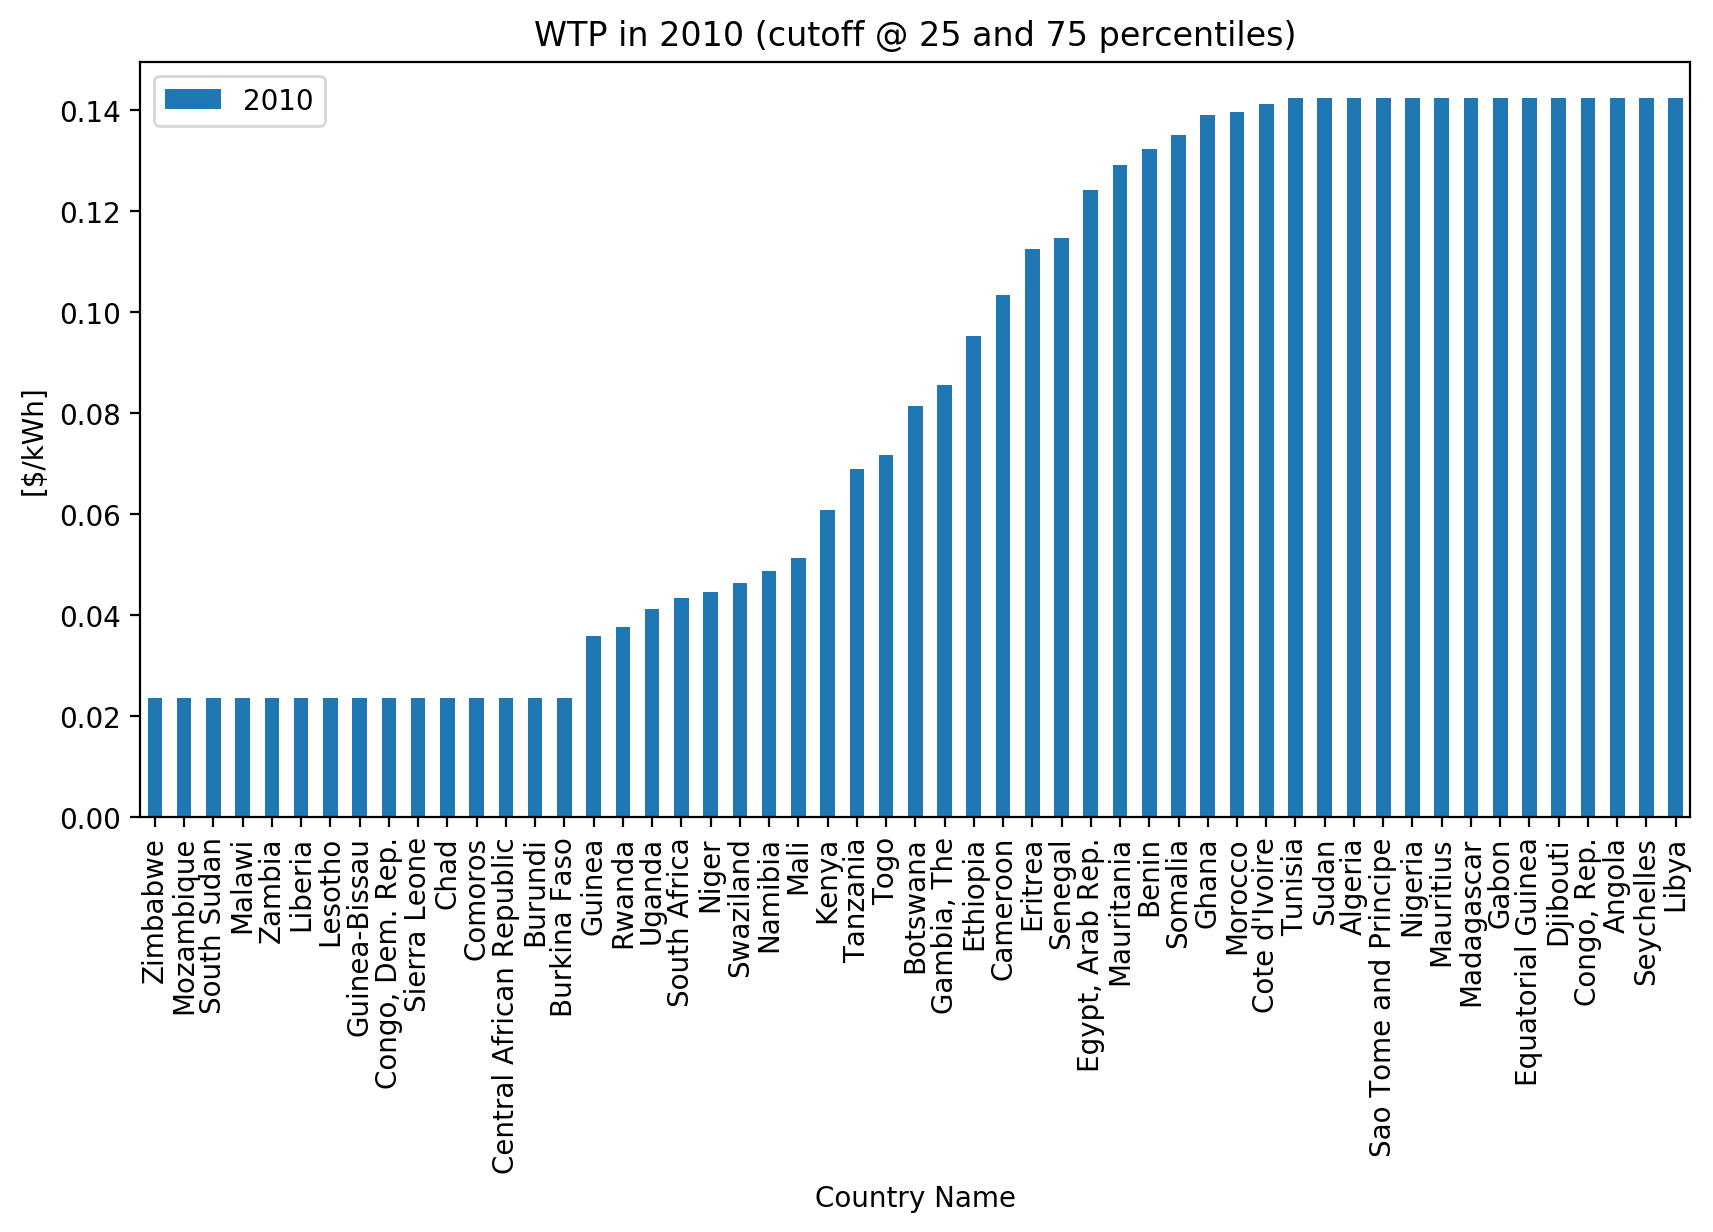

In [10]:
wtp_2010_cutoff = wtp_2010.clip(lower = wtp_2010.quantile(q=0.25).values[0],\
                                upper = wtp_2010.quantile(q=0.75).values[0]).sort_values(by='2010')
ax = wtp_2010_cutoff.plot(kind='bar',figsize = (10,5))
plt.ylabel('[$/kWh]')
plt.title('WTP in 2010 (cutoff @ 25 and 75 percentiles)')
plt.gcf().set_dpi(200)

# WTP projection

Now we take the $WTP_{2010}$ values and we apply growth rates derived from the GDP projections that we have in TIAM-ECN (from ETP 2012). Later we can do the same using e.g. SSP prjections. 


In [11]:
# ==========
# Input data
# ==========
# The only extra data we need are the GDP growth factors
gc = pd.read_excel(data_dir+"\\gdp_coeff.xlsx", sheet_name="Data")
# add country names
gc = gdp_his[['Country Name', 'REG-TIAM_all']].merge(gc, on='REG-TIAM_all')\
                                              .sort_values(by='Country Name')\
                                              .reset_index().drop('index',axis=1)

# Starting from 2015, turn them into multipliers by adding 1 and taking the 5th power
gc_norm = (gc.iloc[:,4:]+1)**5

# take the cumulative products 
# (so that later we only need to multiply the 2010 value)
gc_norm = gc_norm.cumprod(axis=1)

# add the country names
gc = pd.concat([gc.iloc[:,:2],gc_norm],axis=1)

# drop columns 2015, 2025, 2035, etc.
gc = gc.loc[:,gc.columns.str[-1]!='5']

# index by country name
gc = gc.pivot_table(index='Country Name')

# Add 2010 column (with value = 1, because all multipliers are wrt 2010)
gc.loc[:,'2010'] = 1.

# turn the column into strings for compatibility with WB datasets
gc = gc[['%s'%y for y in range(2010,2110,10)]]
gc.head()

,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
Country Name,,,,,,,,,,
Algeria,1.0,1.526247,2.456622,3.833348,5.579400,7.775737,10.680469,14.581724,19.847769,26.974691
Angola,1.0,1.720478,3.432004,6.397074,10.594464,16.101816,23.044293,32.115705,44.166397,60.335593
Benin,1.0,2.025654,3.801610,6.401895,10.403184,16.546499,24.728934,35.220939,48.967195,67.259559
Botswana,1.0,1.602057,2.517832,4.170123,6.368127,9.224397,12.980493,17.937775,24.564190,33.485992
Burkina Faso,1.0,2.025654,3.801610,6.401895,10.403184,16.546499,24.728934,35.220939,48.967195,67.259559


In [12]:
# Make a matrix with the same cols as gc, and fill it with WTP_2010 values
for y in range(2020,2110,10):
    #gdp_2010.loc[:,'%s'%y] = gdp_2010.loc[:,'2010']
    wtp_2010_cutoff.loc[:,'%s'%y] = wtp_2010_cutoff.loc[:,'2010']

# Multiply by (1+log(gc)) to make projection 
# and by 1000 to get $/MWh as unit
wtp_proj_e = 1000 * wtp_2010_cutoff * (1+np.log(gc)) # natural log
wtp_proj_10 = 1000 * wtp_2010_cutoff * (1+np.log10(gc)) # base 10 log
wtp_proj_df = 1000 * wtp_2010_cutoff * gc**0.4  # decoupling factor

# Alternative projection:
#wtp_proj = 1000 * wtp_2010_cutoff * gc

wtp_proj_e.head()

,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
Country Name,,,,,,,,,,
Algeria,142.503476,202.755584,270.583800,333.990901,387.478519,434.779277,480.011100,524.379873,568.316917,612.038045
Angola,142.503476,219.826201,318.230838,406.967234,478.858937,538.510957,589.596466,636.897224,682.301549,726.756641
Benin,132.393921,225.849825,309.196032,378.195693,442.475306,503.914372,557.110175,603.933507,647.558606,689.581570
Botswana,81.467298,119.861911,156.694045,197.798156,232.288142,262.475561,290.304455,316.655957,342.267716,367.509343
Burkina Faso,23.576186,40.218443,55.060406,67.347592,78.794251,89.735077,99.207975,107.546089,115.314674,122.797957


Let's plot the WTP in 2010 and 2050 in a bar-chart:

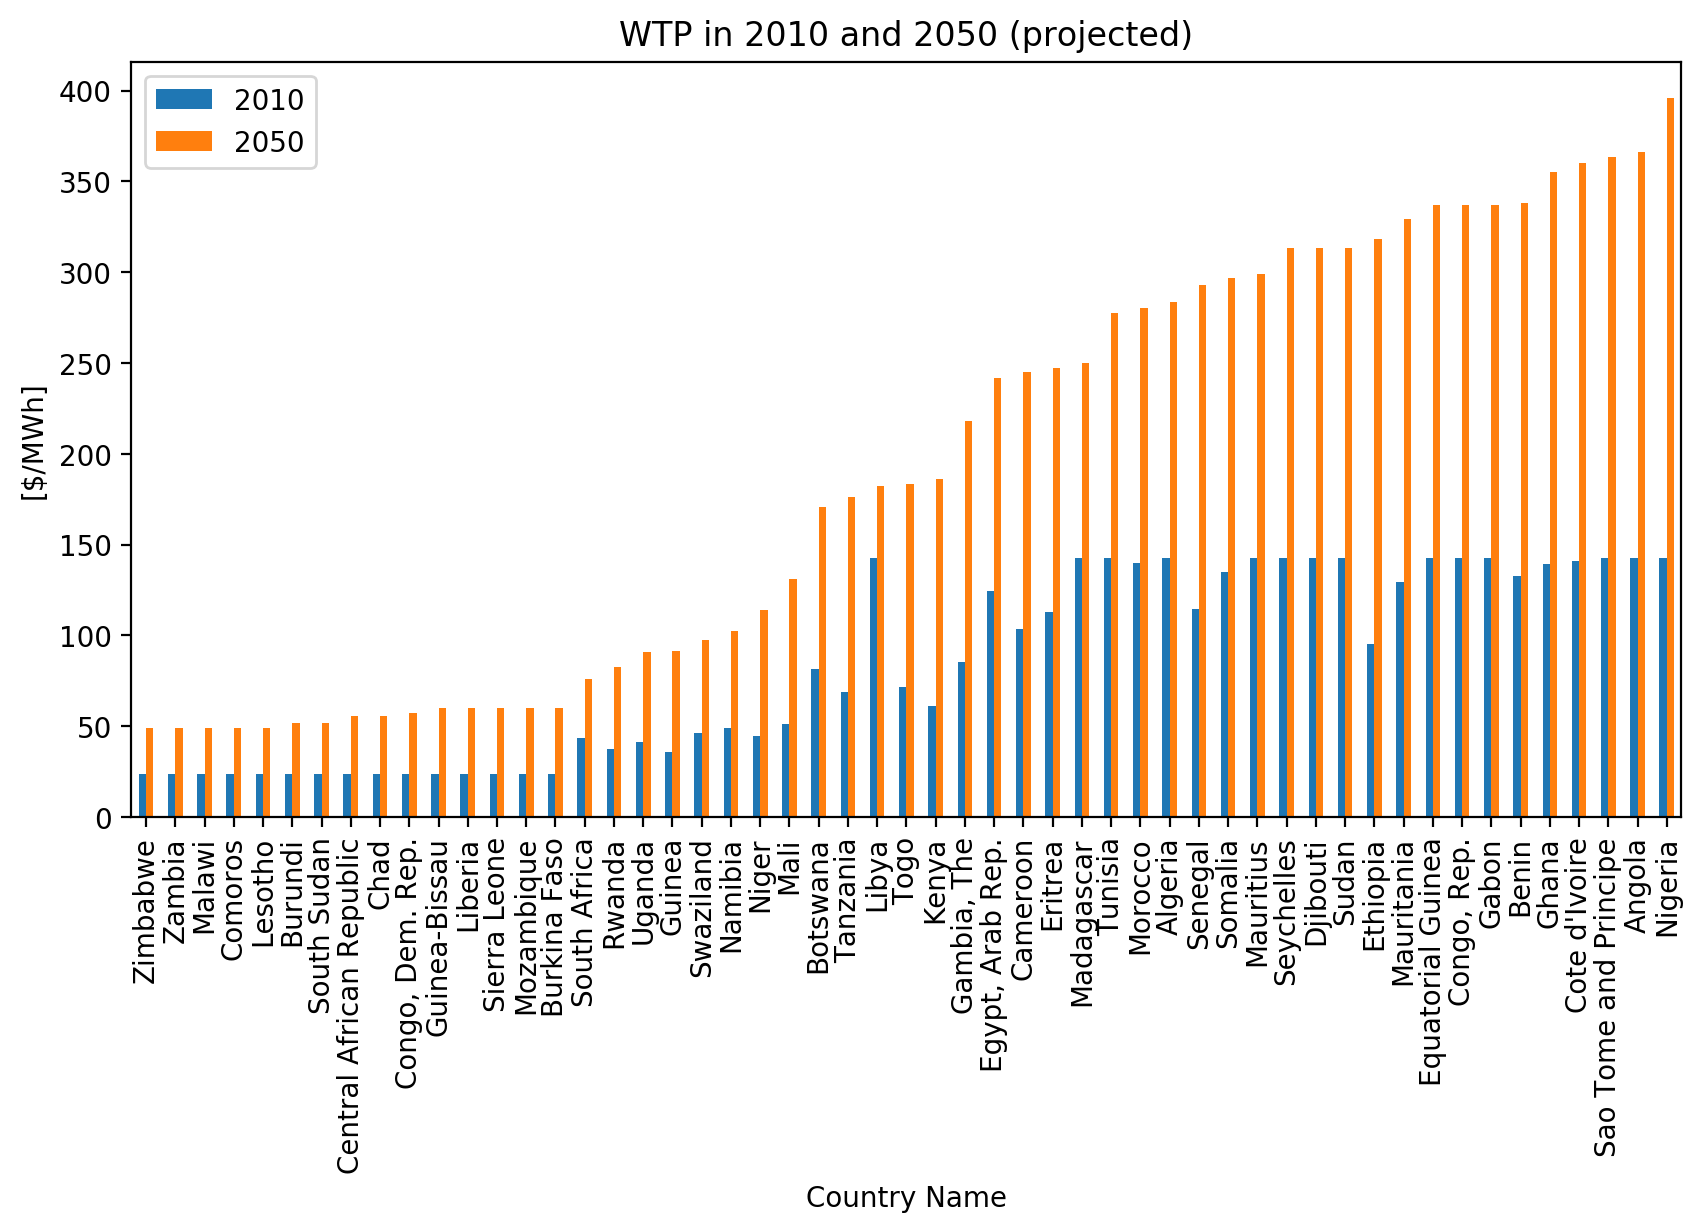

In [13]:
(wtp_proj_df.sort_values(by='2050'))[['2010','2050']].plot(kind='bar', figsize=(10,5))
plt.ylabel('[$/MWh]')
plt.title('WTP in 2010 and 2050 (projected)')
plt.gcf().set_dpi(200)

Let's plot all the data and shade the area between max and min WTP in every year:

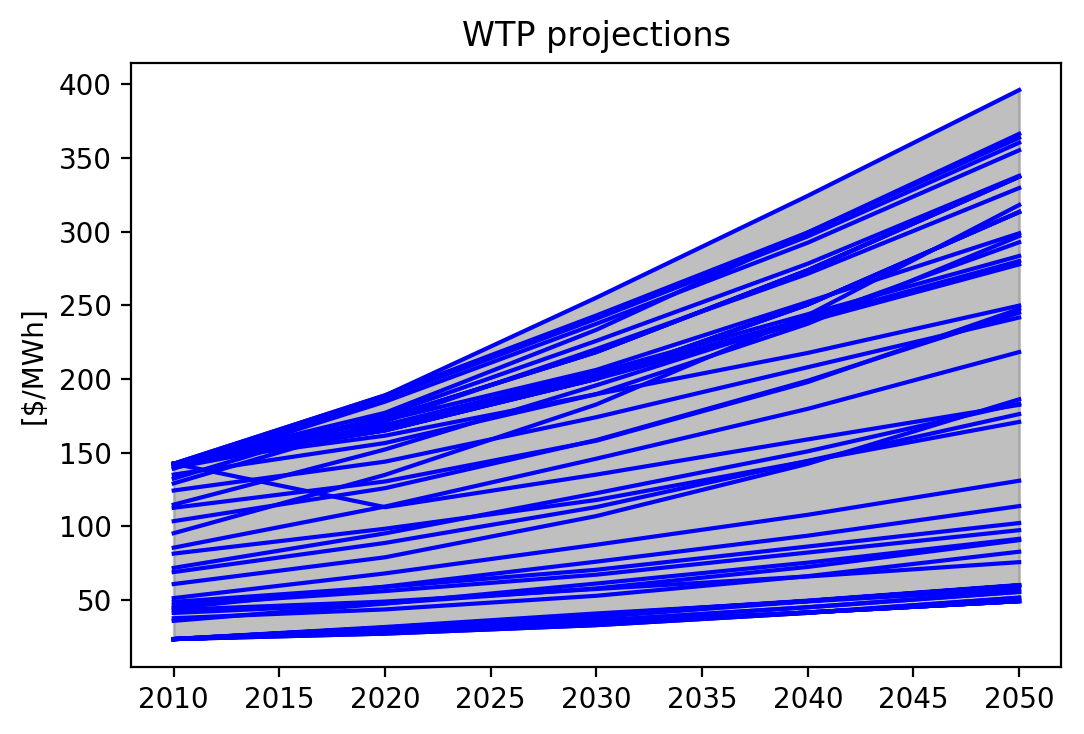

In [14]:
fig, ax = plt.subplots()
top = wtp_proj_df.loc[:,:'2050'].max()
bot = wtp_proj_df.loc[:,:'2050'].min()
x = range(2010, 2060, 10)

ax.fill_between(x, top, bot, alpha=0.5,color='grey')
for s in wtp_proj_df.loc[:,:'2050'].transpose().columns:
    ax.plot(wtp_proj_df.loc[s,:'2050'].transpose(), color='blue')
ax.set_ylabel('[$/MWh]')
ax.set_title('WTP projections')
fig.set_dpi(200)
#fig.savefig('wtp_prj.jpg', dpi=150)

As a final step, let's import the LCOE projections for different off-grid and minigrid technologies from the World Bank (the same  we use in TIAM-ECN):

In [15]:
lcoe_tiam = pd.read_excel(data_dir+"\\LCOE_TIAM-ECN.xlsx", skip_footer=2)
lcoe_tiam

C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\pandas\util\_decorators.py:178: FutureWarning: the 'skip_footer' keyword is deprecated, use 'skipfooter' instead
  return func(*args, **kwargs)


,Category,Tech,2005,2010,2020,2030,2040,2050
0,Wind,Wind \nstand-alone \n(300 W),541.053814,311.126777,283.752925,265.040762,246.735756,228.466529
1,Wind,Wind \nmini-grid \n(100kW),319.793861,195.853310,181.793572,172.228272,162.905633,153.604318
2,Solar PV,Solar PV \nstand-alone \n(300 W),543.516989,272.953374,237.900512,192.406742,156.605621,124.630982
3,Solar PV,Solar PV \nmini-grid \n(25 kW),496.210127,251.917635,220.011939,178.660193,146.096750,116.887223
4,Hydro,Hydro \nstand-alone \n(300 W),166.017658,158.839546,157.403924,157.403924,157.403924,157.403924
5,Hydro,Hydro \nmini-grid \n(100 kW),124.205809,119.202561,118.432830,118.432830,118.432830,118.432830
6,Diesel,Diesel \nstand-alone \n(300 W),167.619118,163.803126,163.326127,163.326127,163.326127,163.326127
7,Diesel,Diesel \nmini-grid \n(100 kW),160.374325,159.655189,159.575285,159.575285,159.575285,159.575285


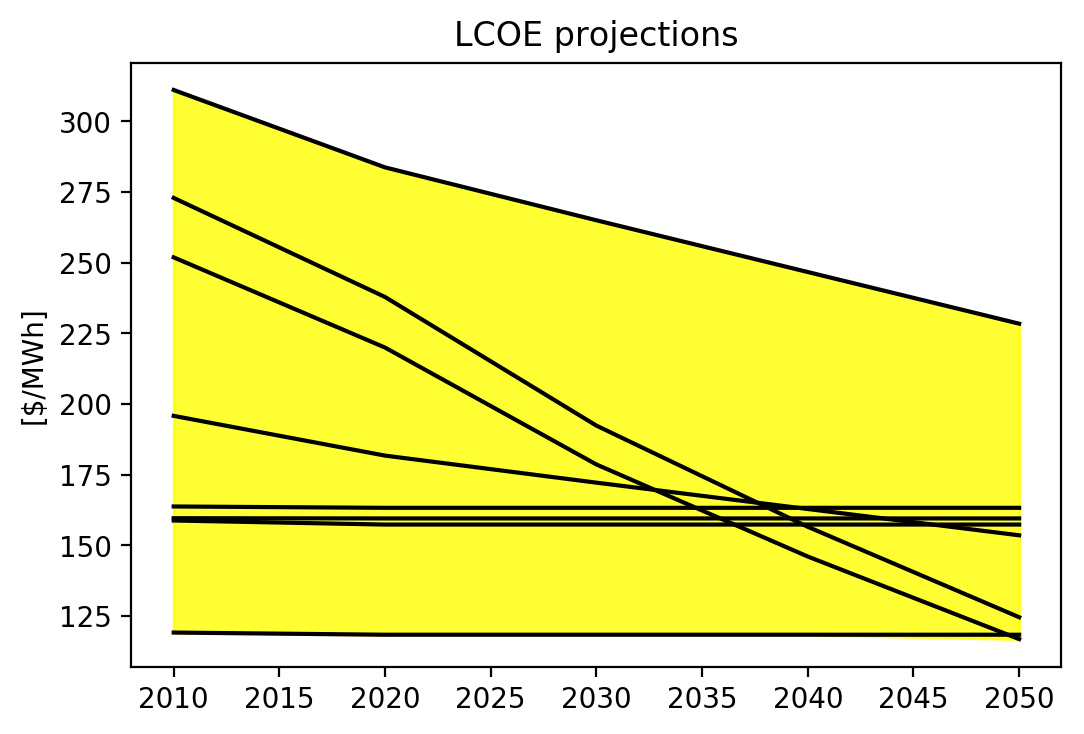

In [16]:
fig, ax = plt.subplots()
x = range(2010, 2060, 10)

lcoe_top = lcoe_tiam.iloc[:,3:].max()
lcoe_bot = lcoe_tiam.iloc[:,3:].min()
ax.fill_between(x, lcoe_top, lcoe_bot, alpha=0.8,color='yellow')
for t in lcoe_tiam.Tech:
    ax.plot(lcoe_tiam[lcoe_tiam.Tech==t].transpose().iloc[3:,:], color='black')

ax.set_ylabel('[$/MWh]')
ax.set_title('LCOE projections')
fig.set_dpi(200)

We can now make a plot to compare the LCOE and the WTP projections. (Note that this country-level comparison is only indicative. Later in the off-grid analysis we will make a much more detailed comparison, where the LCOEs will be specified per raster cell). 

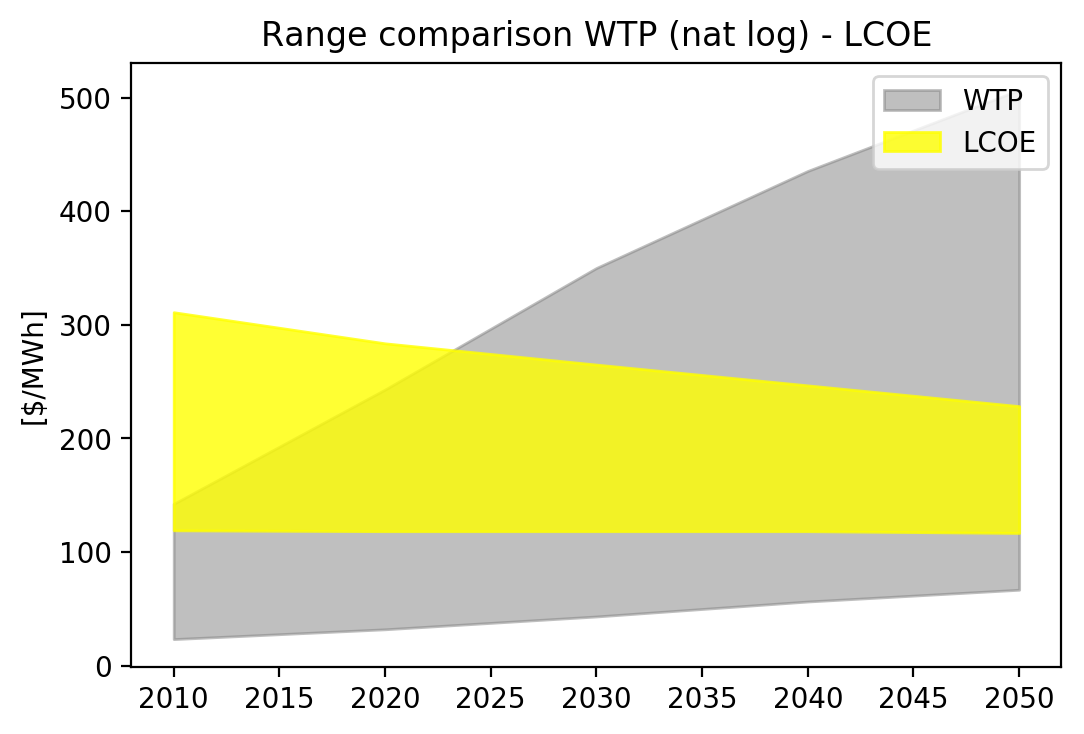

In [17]:
fig, ax = plt.subplots()
x = range(2010, 2060, 10)

# WTP
top = wtp_proj_e.loc[:,:'2050'].max()
bot = wtp_proj_e.loc[:,:'2050'].min()
ax.fill_between(x, top, bot, alpha=0.5,color='grey')
#for s in wtp_proj.loc[:,:'2050'].transpose().columns:
#    ax.plot(wtp_proj.loc[s,:'2050'].transpose(), color='blue')
    
# LCOE
lcoe_top = lcoe_tiam.iloc[:,3:].max()
lcoe_bot = lcoe_tiam.iloc[:,3:].min()
ax.fill_between(x, lcoe_top, lcoe_bot, alpha=0.8,color='yellow')
#for t in lcoe_tiam.Tech:
#    ax.plot(lcoe_tiam[lcoe_tiam.Tech==t].transpose().iloc[3:,:], color='black')

ax.set_ylabel('[$/MWh]')
ax.legend(['WTP','LCOE'])
ax.set_title('Range comparison WTP (nat log) - LCOE')
fig.set_dpi(200)

Some countries in our WTP projection do not make it into the LCOE range. This means that off-grid access will remain 0 for these countries. In the future we might try to use different GDP projections to derive the WTP growth rates, and see whether the picture changes. Part of the issue may have to do with the fact that we used the GDP growth rates that we currently have in TIAM-ECN. These are region-specific and we simply extended the regional value to all countries in the region. Using country-specific projections (e.g. SSP) might be better. 

If we use base 10 logarithm we get that even less countries make it into the yellow range before 2050, but on the other hand the top of the envelope stays below 300 $/MWh, which is a more realistic WTP value: 

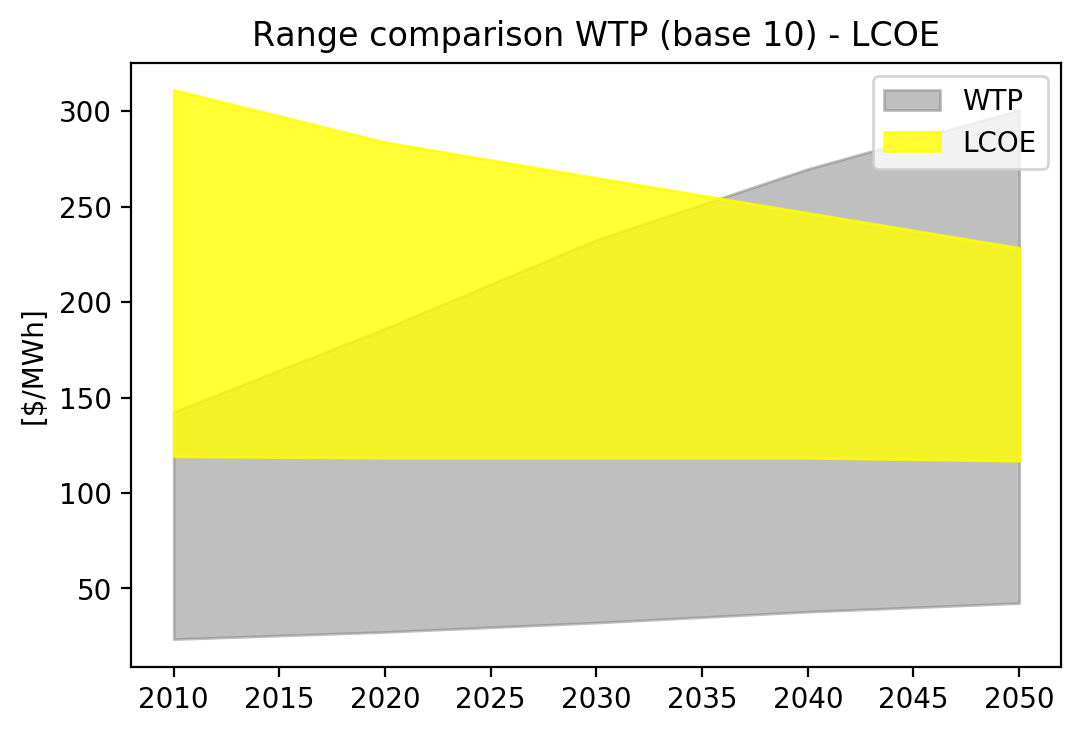

In [18]:
fig, ax = plt.subplots()
x = range(2010, 2060, 10)

# WTP
top = wtp_proj_10.loc[:,:'2050'].max()
bot = wtp_proj_10.loc[:,:'2050'].min()
ax.fill_between(x, top, bot, alpha=0.5,color='grey')
#for s in wtp_proj.loc[:,:'2050'].transpose().columns:
#    ax.plot(wtp_proj.loc[s,:'2050'].transpose(), color='blue')
    
# LCOE
lcoe_top = lcoe_tiam.iloc[:,3:].max()
lcoe_bot = lcoe_tiam.iloc[:,3:].min()
ax.fill_between(x, lcoe_top, lcoe_bot, alpha=0.8,color='yellow')
#for t in lcoe_tiam.Tech:
#    ax.plot(lcoe_tiam[lcoe_tiam.Tech==t].transpose().iloc[3:,:], color='black')

ax.set_ylabel('[$/MWh]')
ax.legend(['WTP','LCOE'])
ax.set_title('Range comparison WTP (base 10) - LCOE')
fig.set_dpi(200)

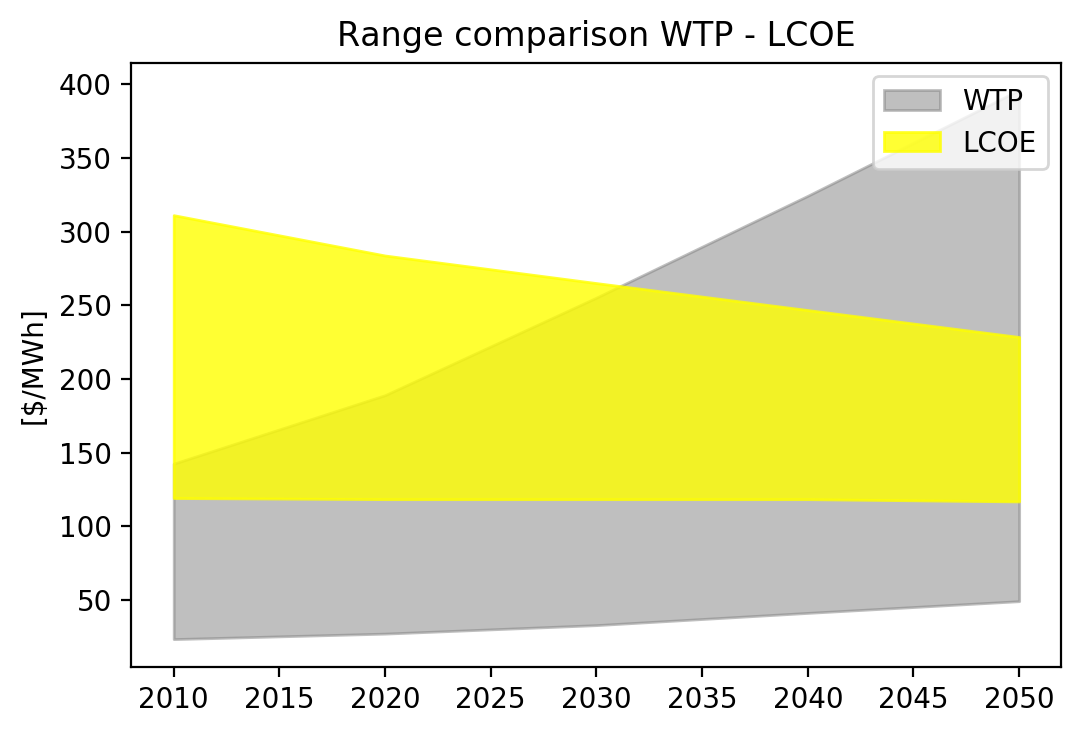

In [19]:
fig, ax = plt.subplots()
x = range(2010, 2060, 10)

# WTP
top = wtp_proj_df.loc[:,:'2050'].max()
bot = wtp_proj_df.loc[:,:'2050'].min()
ax.fill_between(x, top, bot, alpha=0.5,color='grey')
#for s in wtp_proj.loc[:,:'2050'].transpose().columns:
#    ax.plot(wtp_proj.loc[s,:'2050'].transpose(), color='blue')
    
# LCOE
lcoe_top = lcoe_tiam.iloc[:,3:].max()
lcoe_bot = lcoe_tiam.iloc[:,3:].min()
ax.fill_between(x, lcoe_top, lcoe_bot, alpha=0.8,color='yellow')
#for t in lcoe_tiam.Tech:
#    ax.plot(lcoe_tiam[lcoe_tiam.Tech==t].transpose().iloc[3:,:], color='black')

ax.set_ylabel('[$/MWh]')
ax.legend(['WTP','LCOE'])
ax.set_title('Range comparison WTP - LCOE')
fig.set_dpi(200)
#fig.savefig('wtp_lcoe.jpg', dpi=150)

In [21]:
wtp_proj_df.to_excel("wtp_projections.xlsx")

## maps

In [15]:
import geopandas as gpd
import matplotlib as mpl
wtp = gpd.read_file("C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR\\gis_layers\\off-grid_access\\wtp_vec.shp")
wtp.head()

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,Country Na,wtp-2010,...,bin2020sum,bin2030cou,bin2030sum,bin2040cou,bin2040sum,bin2050cou,bin2050sum,popcount,popsum,geometry
0,1,ALG,Algeria,Algeria,North Africa,2325210.0,407605757.0,175.298471,Algeria,142,...,2324648.0,2325210.0,2325205.0,2325210.0,2325210.0,2325210.0,2325210.0,2325210.0,25050021.0,"POLYGON ((1894589.42156076 6093196.823427028, ..."
1,2,ANG,Angola,Angola,Central Africa,1247523.0,248776781.0,199.416589,Angola,142,...,1247361.0,1247523.0,1247361.0,1247523.0,1247431.0,1247523.0,1247431.0,1247523.0,15307500.0,"POLYGON ((3809405.5247603 2283690.127493567, 3..."
2,3,ANG,Angola,Angola,Central Africa,7152.0,1699358.0,237.605984,Angola,142,...,7142.0,7152.0,7151.0,7152.0,7151.0,7152.0,7151.0,7152.0,214484.0,"POLYGON ((3744504.513407562 2674551.841173306,..."
3,4,ANG,Angola,Angola,Central Africa,102.0,21784.0,213.568627,Angola,142,...,99.0,102.0,99.0,102.0,99.0,102.0,99.0,102.0,0.0,"POLYGON ((3650051.721446254 1343900.192709396,..."
4,5,ANG,Angola,Angola,Central Africa,21.0,4608.0,219.428571,Angola,142,...,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,57.0,"POLYGON ((3755607.506678306 2543061.0734161, 3..."


In [9]:
wtpdata = wtp.loc[:,wtp.columns.str.contains('wtp-')]
wtpdata.head()

,wtp-2010,wtp-2020,wtp-2030,wtp-2040,wtp-2050,wtp-2060,wtp-2070,wtp-2080,wtp-2090,wtp-2100
0,142,202,270,333,387,434,480,524,568,612
1,142,219,318,406,478,538,589,636,682,726
2,142,219,318,406,478,538,589,636,682,726
3,142,219,318,406,478,538,589,636,682,726
4,142,219,318,406,478,538,589,636,682,726


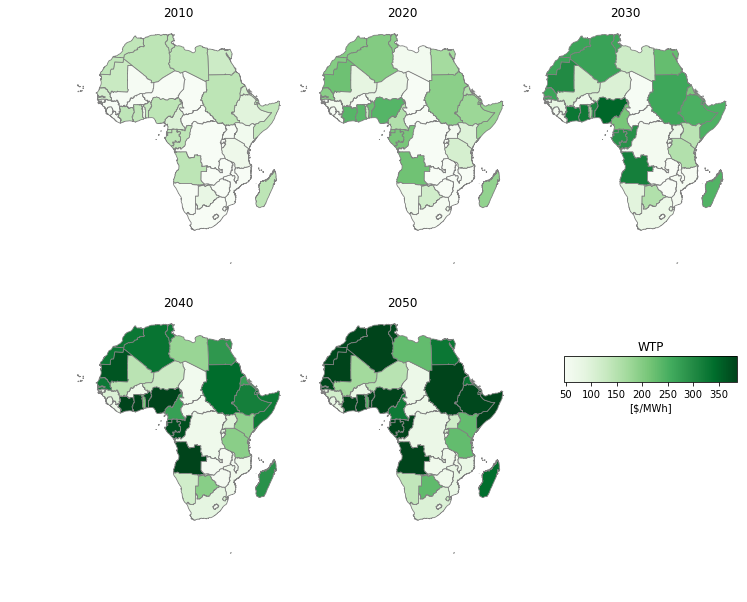

In [32]:
fig = plt.figure()
fig.set_size_inches(12, 12)
fig.subplots_adjust(hspace=-0.2, wspace=0.0)
cmap = 'Greens'
vmin = wtpdata[wtpdata>0].min().min() * 2
vmax = wtpdata.max().max()/2
cols = wtpdata.columns
for i in range(5):
    year = cols[i].split('-')[1]
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(year)
    wtp.plot(ax=ax, column = cols[i], cmap = cmap, edgecolor='grey', linewidth=0.8,\
                     vmin=vmin, vmax=vmax)
cbax = fig.add_subplot(2, 3, 6)
cbax.set_position([0.70,0.40,0.20,0.03]) # [left, bottom, width, height]
cbax.set_title('WTP')
cb = mpl.colorbar.ColorbarBase(cbax, cmap=cmap,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax),
                               orientation='horizontal')
cb.set_label('[$/MWh]')

#fig.savefig(gis_dir+'\\output\\access.png', dpi=150)


23.0